# Structure abstraction

In [1]:
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True

To enable using systems and linked structure files in training deep learning models, we've implemented a number of useful functions to align, mask, and featurize proteins and ligands.

For this, we convert our `PlinderSystem` to a `Structure` object.

In [2]:
from plinder.core import PlinderSystem

plinder_system = PlinderSystem(system_id="4agi__1__1.C__1.W")

system_structure = plinder_system.holo_structure

2024-11-27 10:09:04,553 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-11-27 10:09:04,553 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-11-27 10:09:04,701 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-11-27 10:09:04,701 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-11-27 10:09:04,702 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-11-27 10:09:04,708 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-11-27 10:09:04,708 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 0.15s


- We list all fields and their `FieldInfo` to show which ones are required. `id`, `protein_path` and `protein_sequence` are required. Everything else is optional.
Particularly worth mentioning is the decision to make `list_ligand_sdf_and_input_smiles` optional; this is because ligand will not be availbale in apo and predicted structures.
- Out of these field `ligand_mols` and `protein_atom_array` is computed within the object if set to default. 
- `ligand_mols` returns a chain-mapped dictionary of of the form:
    ```
    {
        "<instance_id>.<chain_id>": (
            RDKit 2D mol from template SMILES of type `Chem.Mol`,
            RDKit mol from template SMILES with random 3D conformer of type `Chem.Mol`,
            RDKit mol of solved (holo) ligand structure of type `Chem.Mol`,
            paired stacked arrays (template vs holo) mapping atom order by index of type `tuple[NDArray.int_, NDArray.int_]`
        )

    }
    ```
- While `protein_atom_array` returns [biotite AtomArray](https://www.biotite-python.org/latest/apidoc/biotite.structure.AtomArray.html) of the receptor protein structure.
- `add_ligand_hydrogens` specifies whether to add explicit hydrogens to the ligand input structures
- `structure_type`: could be `"holo"`, `"apo"` or `"pred"`

In [3]:
system_structure.model_fields

{'id': FieldInfo(annotation=str, required=True),
 'protein_path': FieldInfo(annotation=Path, required=True),
 'protein_sequence': FieldInfo(annotation=Union[dict[str, str], NoneType], required=False, default=None),
 'ligand_sdfs': FieldInfo(annotation=Union[dict[str, str], NoneType], required=False, default=None),
 'ligand_smiles': FieldInfo(annotation=Union[dict[str, str], NoneType], required=False, default=None),
 'protein_atom_array': FieldInfo(annotation=Union[AtomArray, NoneType], required=False, default=None),
 'ligand_mols': FieldInfo(annotation=Union[dict[str, tuple[Mol, Mol, Mol, tuple[ndarray[Any, dtype[+_ScalarType_co]], ndarray[Any, dtype[+_ScalarType_co]]]]], NoneType], required=False, default=None),
 'add_ligand_hydrogens': FieldInfo(annotation=bool, required=False, default=False),
 'structure_type': FieldInfo(annotation=str, required=False, default='holo')}

## Ligand

The ligands are information is provided using dictionaries.

These dictionaries contain information for each ligand using chain tag key:
- `input_ligand_templates`: 2D RDKit mols generated from the RDKit canonical SMILES
- `input_ligand_conformers`: 3D (random) conformers generated for each input mol
- `input_ligand_conformers_atom_array`: biotite atom array object for each input mol
- `input_ligand_conformers_coords`: positional coordintates for 3D conformers
- `resolved_ligand_mols`: RDKit mols of resolved (holo) ligand structures
- `resolved_ligand_mols_atom_array`: biotite atom array object for each resolved mol
- `resolved_ligand_mols_coords`: positional coordintates for holo ligand structures
- `ligand_template2resolved_atom_order_stacks`: paired stacked arrays (template vs holo) mapping atom order by index

Additional property provided as an ordered list
- `ligand_chain_ordered`: ordered list of all ligands by their chain tag keys

In [4]:
for name in system_structure.get_properties():
    if "ligand" in name:
        print(name)

input_ligand_conformers
input_ligand_conformers_atom_array
input_ligand_conformers_coords
input_ligand_templates
ligand_chain_ordered
ligand_template2resolved_atom_order_stacks
resolved_ligand_mols
resolved_ligand_mols_atom_array
resolved_ligand_mols_coords


### Ligand atom id mapping mapping

Unlike the protein sequence - there is no canonical order to ligand atoms in the molecule.
It can be further complicated by automorphisms present in the structure due to symmetry, i.e. there is more than one match that is possible between the structures.

This is important when calculating ligand structure loss, as the most optimal atom order can change between the different inference results. Typically, it is accepted to take the atom ordering resulting in the best objective score and use that for the loss calculation.

Occasionally, futher ambiguity arises to to part of the ligand structure being unresolved in the holo structure - this can lead to multiple available matches. We use RascalMCES algorithm from RDKit to provide all the possible matches between the atom order in the input structure (from SMILES) to the resolved holo structure.

This is provided as stacks of atom order arrays that reorder the template and holo indices to provide matches. Each stack is a unique order transformation and should be iterated.

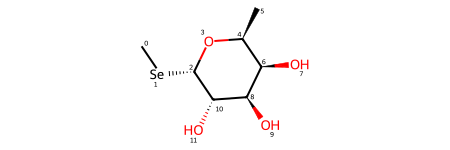

In [5]:
system_structure.input_ligand_templates[system_structure.ligand_chain_ordered[0]]

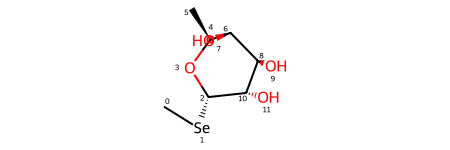

In [6]:
system_structure.input_ligand_conformers[system_structure.ligand_chain_ordered[0]]

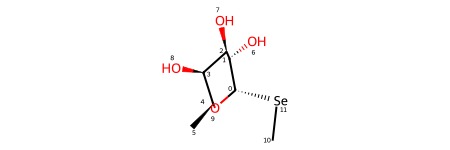

In [7]:
system_structure.resolved_ligand_mols[system_structure.ligand_chain_ordered[0]]

### Ligand conformer coordinates

As you can tell, the input 2D and 3D conformer indices match, but the resolved ligand is different.
Thus to perform a correct comparison for their coordinates one should use atom order stacks.


In [8]:
(
    input_atom_order_stack,
    holo_atom_order_stack,
) = system_structure.ligand_template2resolved_atom_order_stacks[
    system_structure.ligand_chain_ordered[0]
]
input_atom_order_stack, holo_atom_order_stack

(array([[ 2, 10,  8,  6,  4,  5, 11,  9,  7,  3,  0,  1]]),
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]))

In [9]:
system_structure.input_ligand_conformers_coords[
    system_structure.ligand_chain_ordered[0]
][input_atom_order_stack]

array([[[-0.41258365, -1.47247022,  0.19190594],
        [ 1.04999734, -1.31344674,  0.34536287],
        [ 1.50924512, -0.06954471,  1.01688023],
        [ 0.4414304 ,  1.02662908,  1.03100725],
        [-0.3494052 ,  0.75274865, -0.25509704],
        [-1.06483789,  1.95295446, -0.7530481 ],
        [ 1.71111848, -1.47775582, -0.89392989],
        [ 2.00933227, -0.2610022 ,  2.29662695],
        [-0.39876476,  0.72847291,  2.10418674],
        [-1.13885328, -0.33293265,  0.02358181],
        [-2.14780406, -1.84614112, -2.48741362],
        [-0.8344732 , -2.66267578, -1.31015471]]])

In [10]:
system_structure.input_ligand_conformers_coords[
    system_structure.ligand_chain_ordered[0]
][input_atom_order_stack]

array([[[-0.41258365, -1.47247022,  0.19190594],
        [ 1.04999734, -1.31344674,  0.34536287],
        [ 1.50924512, -0.06954471,  1.01688023],
        [ 0.4414304 ,  1.02662908,  1.03100725],
        [-0.3494052 ,  0.75274865, -0.25509704],
        [-1.06483789,  1.95295446, -0.7530481 ],
        [ 1.71111848, -1.47775582, -0.89392989],
        [ 2.00933227, -0.2610022 ,  2.29662695],
        [-0.39876476,  0.72847291,  2.10418674],
        [-1.13885328, -0.33293265,  0.02358181],
        [-2.14780406, -1.84614112, -2.48741362],
        [-0.8344732 , -2.66267578, -1.31015471]]])

In [11]:
system_structure.resolved_ligand_mols_coords[system_structure.ligand_chain_ordered[0]][
    holo_atom_order_stack
]

array([[[48.954, 28.186, 62.068],
        [48.681, 29.643, 61.777],
        [48.556, 29.933, 60.282],
        [47.499, 28.988, 59.699],
        [47.948, 27.56 , 59.939],
        [46.992, 26.503, 59.374],
        [49.72 , 30.41 , 62.383],
        [48.255, 31.352, 60.148],
        [46.262, 29.193, 60.366],
        [48.031, 27.383, 61.339],
        [50.647, 25.895, 62.426],
        [50.853, 27.716, 61.696]]])

Similar can be achieved for biotite atom arrays

In [12]:
import numpy as np

np.array(
    system_structure.input_ligand_conformers_atom_array[
        system_structure.ligand_chain_ordered[0]
        ]
)[input_atom_order_stack]

array([[Atom(np.array([-0.4126, -1.4725,  0.1919], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="", hetero=False, atom_name="", element="C"),
        Atom(np.array([ 1.05  , -1.3134,  0.3454], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="", hetero=False, atom_name="", element="C"),
        Atom(np.array([ 1.5092, -0.0695,  1.0169], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="", hetero=False, atom_name="", element="C"),
        Atom(np.array([0.4414, 1.0266, 1.031 ], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="", hetero=False, atom_name="", element="C"),
        Atom(np.array([-0.3494,  0.7527, -0.2551], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="", hetero=False, atom_name="", element="C"),
        Atom(np.array([-1.0648,  1.953 , -0.753 ], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="", hetero=False, atom_name="", element="C"),
        Atom(np.array([ 1.7111, -1.4778, -0.8939], dtyp

### More complicated examples

Symmetry in ligand (automorphism) - two ways of pairwise mapping the atom order of the phtalimide ring

2024-11-27 10:09:10,130 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 4.57s
2024-11-27 10:09:10,284 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.15s
2024-11-27 10:09:13,717 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.58s
2024-11-27 10:09:13,820 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.10s
2024-11-27 10:09:13,821 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-11-27 10:09:13,824 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-11-27 10:09:13,825 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 0.83s


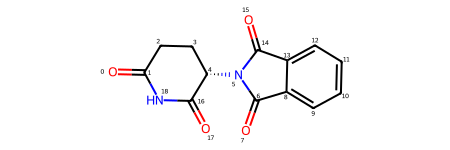

In [13]:
structure_with_symmetry_in_ligand = PlinderSystem(
    system_id="4v2y__1__1.A__1.E"
).holo_structure
structure_with_symmetry_in_ligand.input_ligand_templates[
    structure_with_symmetry_in_ligand.ligand_chain_ordered[0]
]

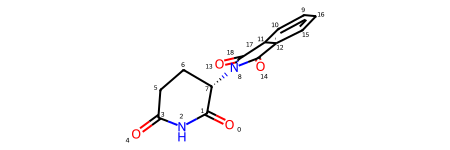

In [14]:
structure_with_symmetry_in_ligand.resolved_ligand_mols[
    structure_with_symmetry_in_ligand.ligand_chain_ordered[0]
]

In [15]:
structure_with_symmetry_in_ligand.ligand_template2resolved_atom_order_stacks[
    structure_with_symmetry_in_ligand.ligand_chain_ordered[0]
]

(array([[17, 16, 18,  1,  0,  2,  3,  4,  5, 10,  9,  8, 13,  7, 15, 12,
         11, 14,  6],
        [17, 16, 18,  1,  0,  2,  3,  4,  5, 11, 12, 13,  8, 15,  7,  9,
         10,  6, 14]]),
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18]]))

Symmetry arises due to ligand being partially resolved - there are three template pieces that can be mapped to the resolved ground truth.

2024-11-27 10:09:21,587 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 7.48s
2024-11-27 10:09:21,681 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:09:26,625 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.62s
2024-11-27 10:09:26,718 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:09:26,719 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-11-27 10:09:26,721 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-11-27 10:09:26,721 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 0.81s


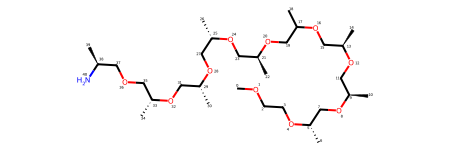

In [16]:
structure_with_partly_resolved_ligand = PlinderSystem(
    system_id="1ngx__1__1.A_1.B__1.E"
).holo_structure
structure_with_partly_resolved_ligand.input_ligand_templates[
    structure_with_partly_resolved_ligand.ligand_chain_ordered[0]
]

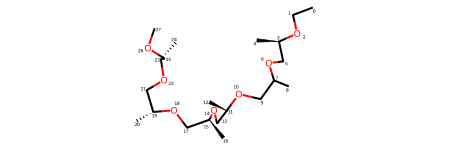

In [17]:
structure_with_partly_resolved_ligand.resolved_ligand_mols[
    structure_with_partly_resolved_ligand.ligand_chain_ordered[0]
]

In [18]:
structure_with_partly_resolved_ligand.ligand_template2resolved_atom_order_stacks[
    structure_with_partly_resolved_ligand.ligand_chain_ordered[0]
]

(array([[ 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
        [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]),
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]]))

## Protein [ WIP ]

The protein information is provided with properties.

#### General properties:
- `protein_chains`: list of all protein chains
- `protein_chain_ordered`: ordered list of all protein chains by their chain tag keys
- `protein_n_atoms`: total number of atoms in protein structure
- `protein_coords`: an array of atomic positions for each protein atom in the structure
- `protein_structure_b_factor`: an array of B-factors for each protein atom in the structure
- `protein_sequence_from_structure`: residue sequence derived from structure


protein_backbone_mask
protein_calpha_mask
protein_calpha_coords
protein_chains
protein_coords
protein_n_atoms
protein_sequence_from_structure
protein_structure_b_factor
protein_structure_tokenized_sequence
protein_unique_atom_names
protein_unique_residue_ids
protein_unique_residue_names

#### Masking

The properties `protein_backbone_mask` and `protein_calpha_mask` are boolean masks that can be used to select backbone or calpha atoms from biotite `AtomArray`. The indices of `True` corresponds to backbone or calpha indices.


In [19]:
np.shape(system_structure.protein_calpha_mask)

()

In [24]:
system_structure.protein_coords[0][list(system_structure.protein_calpha_mask.values())[0]] == system_structure.protein_calpha_coords[0]

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ T

In [25]:
len(system_structure.protein_calpha_coords), len(system_structure.protein_calpha_coords)

(1, 1)

In [26]:
for name in system_structure.get_properties():
    if "protein" in name:
        print(name)

protein_backbone_mask
protein_calpha_coords
protein_calpha_mask
protein_chain_ordered
protein_coords
protein_n_atoms
protein_sequence_from_structure


### Masking


In [31]:
print(
    "Total number of atoms:",
    len(system_structure.protein_atom_array),
)
print("Number of backbone atoms:", sum([b for ch in list(system_structure.protein_backbone_mask.values()) for b in ch]))
print(
    "Number of calpha atoms:",
    sum([b for ch in list(system_structure.protein_calpha_mask.values()) for b in ch]))

Total number of atoms: 2443
Number of backbone atoms: 942
Number of calpha atoms: 314


In [35]:
calpha_atom_array = system_structure.protein_atom_array[
    list(system_structure.protein_calpha_mask.values())[0]
]
calpha_atom_array

array([
	Atom(np.array([48.178, 50.968, 57.827], dtype=float32), chain_id="1.C", res_id=2, ins_code="", res_name="SER", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([49.525, 49.561, 54.51 ], dtype=float32), chain_id="1.C", res_id=3, ins_code="", res_name="THR", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([48.243, 50.024, 50.922], dtype=float32), chain_id="1.C", res_id=4, ins_code="", res_name="PRO", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([47.043, 46.432, 50.946], dtype=float32), chain_id="1.C", res_id=5, ins_code="", res_name="GLY", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([45.205, 46.746, 54.3  ], dtype=float32), chain_id="1.C", res_id=6, ins_code="", res_name="ALA", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([43.543, 49.915, 52.959], dtype=float32), chain_id="1.C", res_id=7, ins_code="", res_name="GLN", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([41.978, 47.864, 50.152], dtype=float32),

You can also filter by arbitrary properties of the `AtomArray` using the `filter` method. This returns a new `Structure` object.

In [36]:
calpha_structure = system_structure.filter(
    property="atom_name",
    mask="CA",
)

In [37]:
calpha_structure.protein_atom_array.coord.shape

(314, 3)

### Get protein chain ordered
This gives a list of protein chains ordered by how they are in the structure

In [38]:
system_structure.protein_chain_ordered

['1.C']

### Get protein chains for all atoms
The list of chain IDs in the structure. Order of how they appear not kept.

In [40]:
system_structure.protein_chain_ordered

['1.C']

### Get protein coordinates
This property gets the 3D positions of each of the atoms in protein molecules

In [41]:
system_structure.protein_coords

[array([[48.761, 52.015, 58.719],
        [48.178, 50.968, 57.827],
        [49.186, 50.593, 56.712],
        ...,
        [50.066, 42.485, 54.198],
        [47.368, 43.433, 55.544],
        [50.022, 44.674, 54.248]], dtype=float32)]

### Get sequence from protein structure


In [42]:
system_structure.protein_sequence_from_structure

{'1.C': 'STPGAQQVLFRTGIAAVNSTNHLRVYFQDVYGSIRESLYEGSWANGTEKNVIGNAKLGSPVAATSKELKHIRVYTLTEGNTLQEFAYDSGTGWYNGGLGGAKFQVAPYSXIAAVFLAGTDALQLRIYAQKPDNTIQEYMWNGDGWKEGTNLGGALPGTGIGATSFRYTDYNGPSIRIWFQTDDLKLVQRAYDPHKGWYPDLVTIFDRAPPRTAIAATSFGAGNSSIYMRIYFVNSDNTIWQVCWDHGKGYHDKGTITPVIQGSEVAIISWGSFANNGPDLRLYFQNGTYISAVSEWVWNRAHGSQLGRSALPPA'}

Note that this is different from the canonical SEQRES sequence due to unresolved terminal residues:

In [43]:
system_structure.protein_sequence

{'1.C': 'MSTPGAQQVLFRTGIAAVNSTNHLRVYFQDVYGSIRESLYEGSWANGTEKNVIGNAKLGSPVAATSKELKHIRVYTLTEGNTLQEFAYDSGTGWYNGGLGGAKFQVAPYSXIAAVFLAGTDALQLRIYAQKPDNTIQEYMWNGDGWKEGTNLGGALPGTGIGATSFRYTDYNGPSIRIWFQTDDLKLVQRAYDPHKGWYPDLVTIFDRAPPRTAIAATSFGAGNSSIYMRIYFVNSDNTIWQVCWDHGKGYHDKGTITPVIQGSEVAIISWGSFANNGPDLRLYFQNGTYISAVSEWVWNRAHGSQLGRSALPPA'}

### More complex example - two proteins [ TO BE FIXED ]

In [ ]:
# plinder_system = PlinderSystem(system_id="5fqd__1__1.B_1.C__1.H")
# system_structure = plinder_system.holo_structure

2024-10-22 12:12:34,047 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-10-22 12:12:34,049 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-10-22 12:12:34,165 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-10-22 12:12:34,166 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-10-22 12:12:34,168 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-10-22 12:12:34,174 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-10-22 12:12:34,175 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 0.12s


In [ ]:
# system_structure.protein_coords[0][system_structure.protein_calpha_mask] == system_structure.protein_calpha_coords[0]
# IndexError: boolean index did not match indexed array along dimension 0; dimension is 3068 but corresponding boolean dimension is 5491

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3068 but corresponding boolean dimension is 5491

## Linked protein input structures [ TO ADD ?]


For realistic inference scenarios we need to initialize our protein structures using a linked structure (introduced above). In most cases, these will not be a perfect match to the _holo_ structure - the number of residues, residue numbering, and sometime the sequnce can be different. It's important to be able to match these structures to ensure that we can map between them. 

In the example below, we will take a _holo_ structure and it's linked predicted (_pred_) form with different number of residues and  match and crop the resulting structures to figure out the correspondence between their residues. For this we use the `align_common_sequence` function of the holo `Structure` object, which aligns two structures based on their shared sequences. It has the following parameters:

```
other: Structure
    The other structure to align to
copy: bool
    Whether to make a copy or edit in-place
remove_differing_atoms: bool
    Whether to remove differing atoms between the two structure
renumber_residues: bool [False]
    If True, renumber residues in the two structures to match and starting from 1.
    If False, sets the resulting residue indices to the one from the aligned sequence
remove_differing_annotations: bool [False]
    Whether to remove differing annotations, like b-factor, etc
```
In this example, we will match, make copies and crop the structures.

:::{note} To use this function the proteins to be aligned must have the same chain ids. So, we first set the chain id of the predicted structure to that of the holo structure. :::

```python
plinder_system = PlinderSystem(system_id="4cj6__1__1.A__1.B")
holo = plinder_system.holo_structure
predicted = plinder_system.alternate_structures["P12271_A"]
predicted.set_chain(holo.protein_chain_ordered[0])
holo_cropped, predicted_cropped = holo.align_common_sequence(predicted)
predicted_cropped_superposed, raw_rmsd, refined_rmsd = predicted_cropped.superimpose(
    holo_cropped
)
```